In [19]:
import os
import time
import torch

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

from models import ShallowNN
from utils import load_file, get_all_possible_pairs
from evals import evaluate, pairwise_euclidean_distance , influence, calculate_hessian_flattened

features = 197
batch_size = 64
loss_fn = torch.nn.L1Loss()

In [3]:
client_ids = ["0_0","0_1","0_2","0_3","0_4","0_5","1_0","1_1","1_2","1_3","1_4","1_5","2_0","2_1","2_2","2_3","2_4","2_5","3_0","3_1","3_2","3_3","3_4","3_5"]

In [7]:
#fed_learning_all_losses = pd.read_csv("losses/fed_learning_stats_64.csv")

In [8]:
"""
fig,axes = plt.subplots(nrows=4,ncols=6,figsize=(60, 30))
for client in client_ids:
    plot_id = client.split("_")
    fed_losses = fed_learning_all_losses.loc[fed_learning_all_losses['client_id'] == client].reset_index().drop(columns=['index','training_round','client_id','fed_train'])
    fed_losses = fed_losses.rename(columns={"validation_loss": "fed_val"})
    iso_losses = pd.read_csv("losses/batch64_client_"+str(client)+".csv").drop(columns=["iso_train"])
    df = pd.concat([fed_losses, iso_losses], axis=1)
    df.plot(ax=axes[int(plot_id[0])][int(plot_id[1])],title=client)
"""

'\nfig,axes = plt.subplots(nrows=4,ncols=6,figsize=(60, 30))\nfor client in client_ids:\n    plot_id = client.split("_")\n    fed_losses = fed_learning_all_losses.loc[fed_learning_all_losses[\'client_id\'] == client].reset_index().drop(columns=[\'index\',\'training_round\',\'client_id\',\'fed_train\'])\n    fed_losses = fed_losses.rename(columns={"validation_loss": "fed_val"})\n    iso_losses = pd.read_csv("losses/batch64_client_"+str(client)+".csv").drop(columns=["iso_train"])\n    df = pd.concat([fed_losses, iso_losses], axis=1)\n    df.plot(ax=axes[int(plot_id[0])][int(plot_id[1])],title=client)\n'

In [9]:
global_model = ShallowNN(features)
global_model.load_state_dict(torch.load('checkpt/_fedl_global_500.pth'))

<All keys matched successfully>

In [10]:
eval_list = []
for client in client_ids:
    
    val_data_path =  "testpt/"+str(client)+".pt"
    val_set = torch.load(val_data_path)
    val_loader = DataLoader(val_set, batch_size, shuffle = True)
    
    isolated_model_path = "checkpt/isolated/batch64_client_"+str(client)+".pth"
    isolated_model =  ShallowNN(features)
    isolated_model.load_state_dict(torch.load(isolated_model_path))
    
    _, _ , isolated_mae = evaluate(isolated_model, val_loader, loss_fn)
    _, _ , global_mae = evaluate(global_model,val_loader,loss_fn)
    
    eval_dict = {"client_id":client, "Isolated Model MAE": round(isolated_mae, 4), "Federated Model MAE" :round(global_mae, 4)}
    eval_list.append(eval_dict)
    
eval_df = pd.DataFrame.from_dict(eval_list)
eval_df["clients"] = [i for i in range(1,25)] 

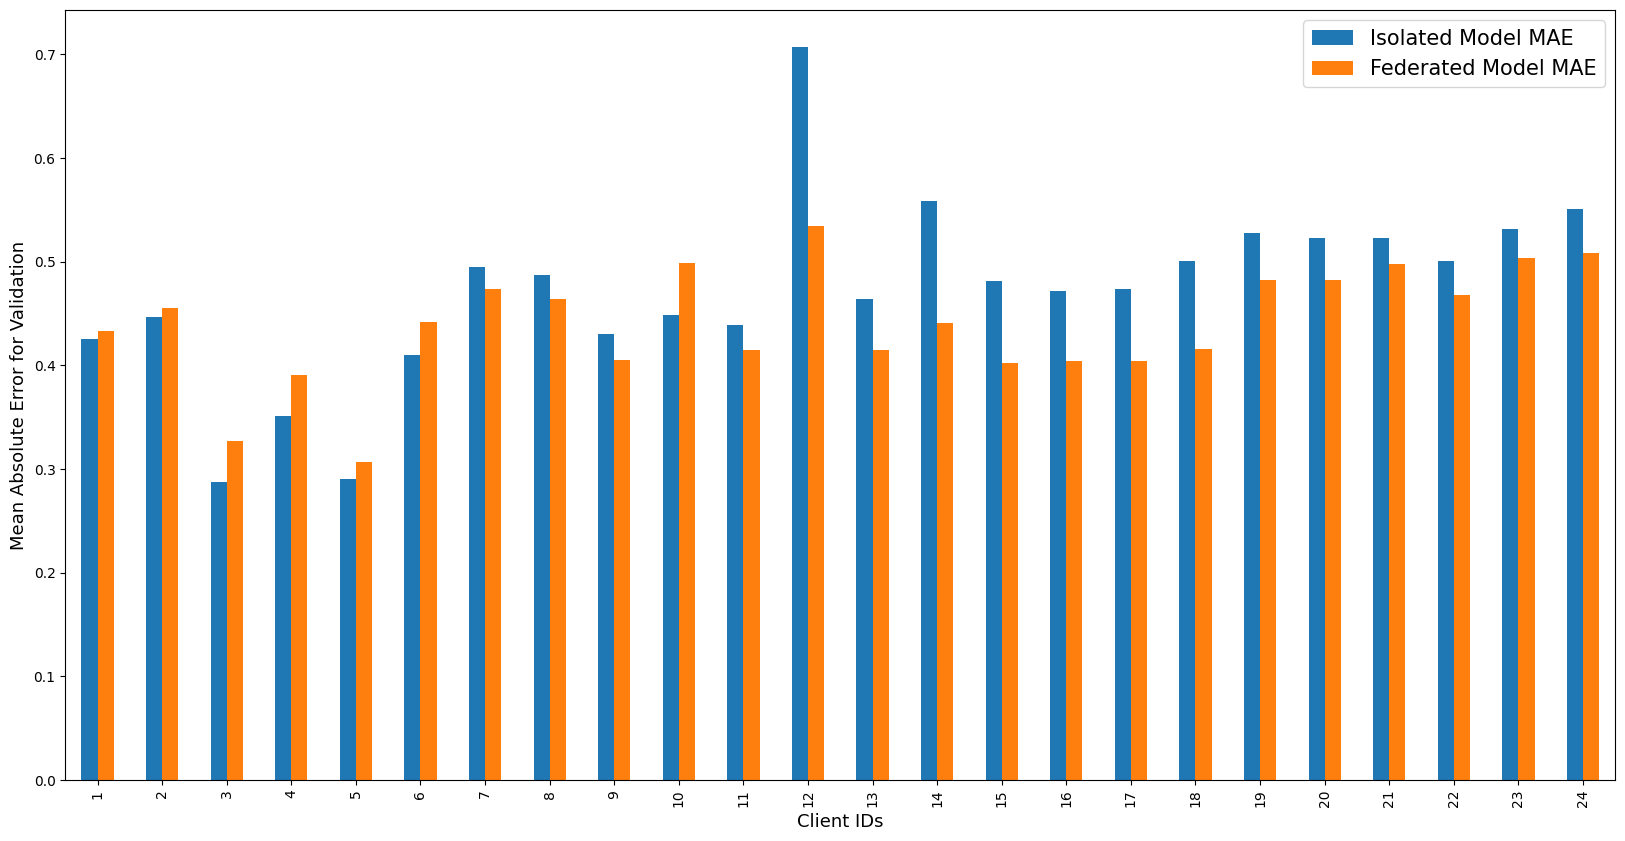

In [11]:
ax = eval_df.plot.bar(x="clients",figsize=(20, 10))
ax.set_ylabel("Mean Absolute Error for Validation",fontdict={'fontsize':13})
ax.set_xlabel("Client IDs",fontdict={'fontsize':13})
ax.legend(fontsize=15, loc="upper right")

In [12]:
ben_list = []
for index, row in eval_df.iterrows():
    ben_list.append(round(row['Isolated Model MAE']-row['Federated Model MAE'],4))
eval_df["Benefict"] = ben_list

In [13]:
eval_df.to_csv("insights/benifict.csv", index= False)

<Axes: xlabel='clients'>

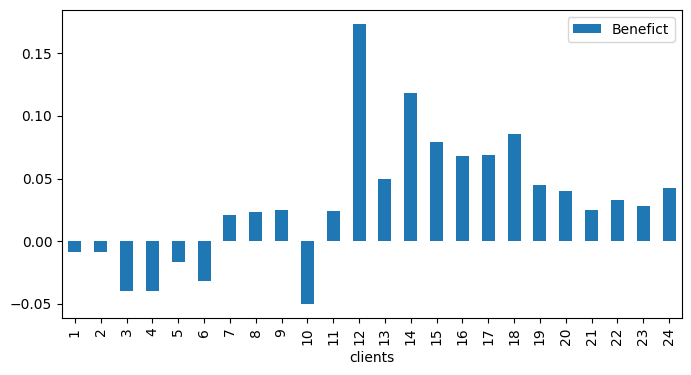

In [14]:
eval_df.plot.bar(x="clients",y="Benefict", figsize=(8, 4))

In [27]:
def influence(global_model, influenced_model):
    eval_list = []
    for client in client_ids:

        val_data_path =  "testpt/"+str(client)+".pt"
        val_set = torch.load(val_data_path)
        val_loader = DataLoader(val_set, batch_size, shuffle = True)

        global_loss, _ , global_mae = evaluate(global_model,val_loader,loss_fn)
        influenced_loss, _ , influenced_mae = evaluate(influenced_model, val_loader, loss_fn)

        eval_dict = {"client_id":client, "global_mae": round(global_mae, 4), 
                     "influenced_mae" :round(influenced_mae, 4),
                    "global_loss": round(global_loss,4),
                    "influenced_loss": round(influenced_loss,4)}
        
        eval_list.append(eval_dict)

    eval_df = pd.DataFrame.from_dict(eval_list)
    
    influence = round(eval_df["global_mae"].sum() - eval_df["influenced_mae"].sum() , 4)
    loss_influence = round(eval_df["global_loss"].sum() - eval_df["influenced_loss"].sum() , 4)
    return eval_df, influence,loss_influence

In [34]:
inf_val = []
loss_inf_val = []
for client in client_ids:
    model = ShallowNN(features)
    model.load_state_dict(torch.load('checkpt/influence/' + str(client)+ '_fedl_global_500.pth'))
    df, inf,loss_inf = influence(global_model,model)
    inf_val.append(abs(inf))
    loss_inf_val.append(abs(loss_inf))
    #df.to_csv("influence2_"+str(client) + ".csv", index=False)

In [35]:
data = {"client id": client_ids, "inf_val": inf_val, "loss_inf_val":loss_inf_val}
data = pd.DataFrame(data)
data.to_csv("insights/influence_with_batch_mae.csv" , index=False)

In [17]:
global_model = ShallowNN(features)
global_model.load_state_dict(torch.load('checkpt/_fedl_global_500.pth'))

def hessian(client):
    
    val_dataset = torch.load("trainpt/"+ str(client)+".pt")
    validation_data_loader = DataLoader(val_dataset, batch_size, shuffle=True)
    
    isolated_model = ShallowNN(features)
    isolated_model_path = "checkpt/isolated/batch64_client_"+str(client)+".pth"
    isolated_model.load_state_dict(torch.load(isolated_model_path))
                                              
    fed_hessian_mat , _  = calculate_hessian_flattened(global_model,loss_fn,validation_data_loader)
    iso_hessian_mat , _ = calculate_hessian_flattened(isolated_model,loss_fn,validation_data_loader)
    
    return fed_hessian_mat, iso_hessian_mat

In [21]:
"""
for client in client_ids:
    fed_hessian_mat , iso_hessian_mat = hessian(client)
    torch.save(fed_hessian_mat, "hessians/fed/"+str(client)+".pth")
    torch.save(iso_hessian_mat, "hessians/iso/"+str(client)+".pth")
    print("Client " +str(client)+ " done.")
"""

'\nfor client in client_ids:\n    fed_hessian_mat , iso_hessian_mat = hessian(client)\n    torch.save(fed_hessian_mat, "hessians/fed/"+str(client)+".pth")\n    torch.save(iso_hessian_mat, "hessians/iso/"+str(client)+".pth")\n    print("Client " +str(client)+ " done.")\n'

In [22]:
from evals import euclidean_distance, pairwise_euclidean_distance, accumulated_proximity, full_accumulated_proximity

In [24]:
full_acc_proximity = full_accumulated_proximity(client_ids,euclidean_distance)

In [25]:
for client in client_ids:
    fed_matrix = torch.load("hessians/fed/" + str(client) + ".pth")
    iso_matrix = torch.load("hessians/iso/" + str(client) + ".pth")
    acc_proximity = accumulated_proximity(fed_matrix,iso_matrix,euclidean_distance)
    
    print(client,acc_proximity, acc_proximity/full_acc_proximity)

0_0 tensor(1086.0940) tensor(0.0015)
0_1 tensor(1087.1829) tensor(0.0015)
0_2 tensor(1158.4735) tensor(0.0016)
0_3 tensor(2138.9832) tensor(0.0029)
0_4 tensor(1130.2997) tensor(0.0015)
0_5 tensor(960.5745) tensor(0.0013)
1_0 tensor(757.3765) tensor(0.0010)
1_1 tensor(1096.7253) tensor(0.0015)
1_2 tensor(1011.8719) tensor(0.0014)
1_3 tensor(2556.1780) tensor(0.0035)
1_4 tensor(1015.6450) tensor(0.0014)
1_5 tensor(1447.0861) tensor(0.0020)
2_0 tensor(1338.3552) tensor(0.0018)
2_1 tensor(1068.7295) tensor(0.0014)
2_2 tensor(944.0541) tensor(0.0013)
2_3 tensor(1253.7213) tensor(0.0017)
2_4 tensor(1221.4220) tensor(0.0017)
2_5 tensor(1225.5518) tensor(0.0017)
3_0 tensor(1537.4397) tensor(0.0021)
3_1 tensor(1068.9072) tensor(0.0014)
3_2 tensor(1307.1589) tensor(0.0018)
3_3 tensor(1231.3860) tensor(0.0017)
3_4 tensor(1650.8738) tensor(0.0022)
3_5 tensor(1640.5499) tensor(0.0022)
